### Цель проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.


Цель проекта: Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

### Загрузите и подготовьте данные. Поясните порядок действий.

In [1]:
# импортируем библиотеки
from IPython.display import display
import os
import pandas as pd



from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler 

from random import randint
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import os
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



pd.options.display.max_columns = None

In [2]:
#импортируем данные

pth1 = '/datasets/Churn.csv'
pth2 ='Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
df.rename(columns = {key:key.lower() for (key) in df.columns}, inplace=True)

df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

array([[<AxesSubplot:title={'center':'rownumber'}>,
        <AxesSubplot:title={'center':'customerid'}>,
        <AxesSubplot:title={'center':'creditscore'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'balance'}>],
       [<AxesSubplot:title={'center':'numofproducts'}>,
        <AxesSubplot:title={'center':'hascrcard'}>,
        <AxesSubplot:title={'center':'isactivemember'}>],
       [<AxesSubplot:title={'center':'estimatedsalary'}>,
        <AxesSubplot:title={'center':'exited'}>, <AxesSubplot:>]],
      dtype=object)

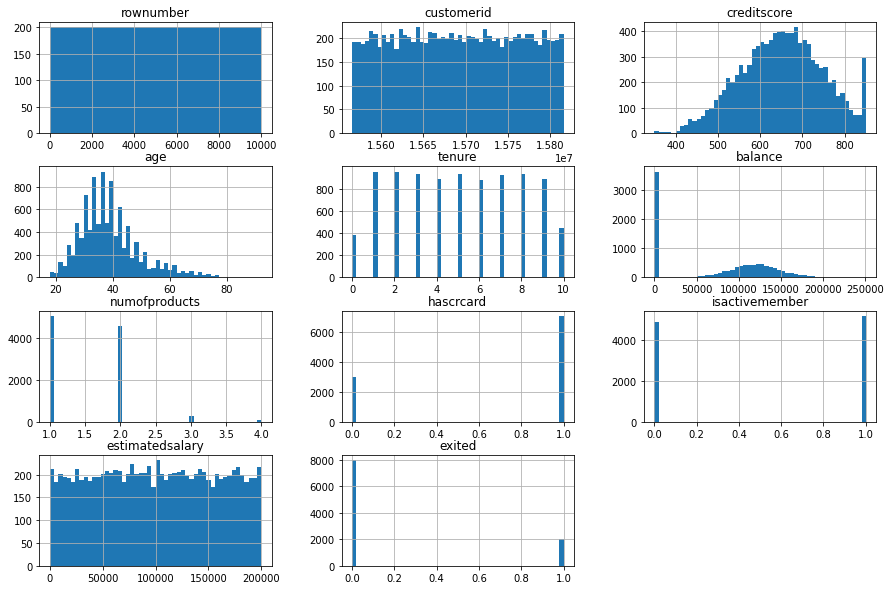

In [4]:
df.hist(bins=50, figsize=(15,10))

Данные распределены относительно нормально, что говорит о достаточном их количестве.

Наблюдается дисбаланс классов, количество "1" вчетверо меньше чем "0".


все столбцы без пропусков, исключая tenure

посмотрим более детально на то, какие данные содержатся в каждом из столбцов данных

In [5]:
# 
for col in df.columns:
    if not "sales" in col:
        print('---------------------------------'+col+'-----------------------------------------')
        print(df.groupby([col], dropna=False, as_index=False).size())

---------------------------------rownumber-----------------------------------------
      rownumber  size
0             1     1
1             2     1
2             3     1
3             4     1
4             5     1
...         ...   ...
9995       9996     1
9996       9997     1
9997       9998     1
9998       9999     1
9999      10000     1

[10000 rows x 2 columns]
---------------------------------customerid-----------------------------------------
      customerid  size
0       15565701     1
1       15565706     1
2       15565714     1
3       15565779     1
4       15565796     1
...          ...   ...
9995    15815628     1
9996    15815645     1
9997    15815656     1
9998    15815660     1
9999    15815690     1

[10000 rows x 2 columns]
---------------------------------surname-----------------------------------------
       surname  size
0        Abazu     2
1        Abbie     1
2       Abbott     4
3     Abdullah     1
4      Abdulov     2
...        ...   ...
2927   Zub

посчитаем доли значений целевого признака

In [6]:
#

exited_yes = df.query('exited == 1')['exited'].count()
exited_no = df.query('exited == 0')['exited'].count()
print('Доля 1 в целевой выборке:',exited_yes/(exited_yes+exited_no))
print('Доля 0 в целевой выборке:',exited_no/(exited_yes+exited_no))

Доля 1 в целевой выборке: 0.2037
Доля 0 в целевой выборке: 0.7963


Наблюдаем дисбаланс классов, необходимо изменить это для улучшения результата.

Поищем дубликаты среди клиентов

In [7]:
df.duplicated(subset=[ 'surname',  'geography',
       'gender', 'age', 'tenure',  'exited']).value_counts()


False    9986
True       14
dtype: int64

In [8]:

df.duplicated(subset=[ 'surname',  'geography',
       'gender', 'age', 'tenure']).value_counts()

False    9982
True       18
dtype: int64

In [9]:

df.duplicated(subset=[ 'surname',  'geography',
       'gender', 'age']).value_counts()

False    9759
True      241
dtype: int64

In [10]:
df.drop_duplicates(subset=[ 'surname',  'geography',
       'gender', 'age'], inplace = True)

In [11]:

df.duplicated(subset=[ 'surname',  'geography',
       'gender', 'age']).value_counts()

False    9759
dtype: int64

In [12]:
df.sample(10)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
5922,5923,15786196,Han,555,France,Female,44,3.0,105770.70,3,1,0,60533.96,1
2442,2443,15772632,Ts'ui,680,France,Female,34,1.0,0.00,2,1,0,167035.07,0
7981,7982,15803032,Yen,599,Germany,Male,38,9.0,89111.63,1,0,0,157239.60,0
9332,9333,15638882,Cardell,710,Germany,Female,62,9.0,148214.36,1,1,0,48571.14,1
1261,1262,15794870,Sal,744,Germany,Male,38,6.0,73023.17,2,1,0,78770.86,0
5378,5379,15720968,Young,606,Germany,Male,27,NaN,130274.26,2,1,0,147533.09,0
6962,6963,15683892,Fraser,677,Germany,Female,26,3.0,102395.79,1,1,0,119368.99,0
3829,3830,15744200,Ni,587,France,Female,36,1.0,70784.27,1,1,0,30579.82,0
8539,8540,15668594,Diggs,620,Germany,Female,25,NaN,137712.01,1,1,1,76197.05,0
3344,3345,15654292,Vessels,565,Germany,Male,33,8.0,130368.31,2,1,0,105642.43,0


In [13]:
df=df.drop(['surname'], axis=1)


In [14]:
df.columns

Index(['rownumber', 'customerid', 'creditscore', 'geography', 'gender', 'age',
       'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember',
       'estimatedsalary', 'exited'],
      dtype='object')

In [15]:
df=df.drop(['rownumber'], axis=1)
df=df.drop(['customerid'], axis=1)

#### пропуски

пропуски в столбце tenures пока оставим как есть.

In [16]:
df['tenure']=df['tenure'].fillna(0)


### Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

In [17]:
#df = pd.concat([df, pd.get_dummies(df['geography'])], axis=1);
#df = pd.concat([df, pd.get_dummies(df['gender'])], axis=1);

In [18]:
df = pd.concat(
    [
        df, 
        pd.get_dummies(df['geography'], drop_first=True),
        pd.get_dummies(df['gender'], drop_first=True)
    ], axis=1
);

Разделите исходные данные на обучающую, валидационную и тестовую выборки.

In [19]:
df=df.drop(['geography'], axis=1)
df=df.drop(['gender'], axis=1)

In [20]:
df.sample(10)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,Germany,Spain,Male
1394,561,29,9.0,120268.13,1,1,1,173870.39,0,0,0,1
9415,768,43,2.0,129264.05,2,0,0,19150.14,0,1,0,0
9833,699,41,1.0,200117.76,2,1,0,94142.35,0,1,0,0
9402,810,69,3.0,27288.43,1,1,1,110509.90,0,1,0,1
3961,702,29,10.0,88378.60,1,1,0,88550.28,0,0,0,0
2412,754,38,2.0,0.00,2,1,0,180698.32,0,0,0,1
4544,673,39,8.0,138160.00,1,1,1,110468.51,0,0,1,1
6533,489,47,8.0,103894.38,2,1,1,107625.46,0,0,0,0
5989,668,53,10.0,110240.04,1,0,0,183980.56,1,0,0,0
73,604,25,5.0,157780.84,2,1,1,58426.81,0,1,0,0


In [21]:
#

features = df.drop(['exited'], axis=1)
target = df['exited']

features_in = df.drop(['exited'], axis=1)
target_in = df['exited']

features, features_test, target, target_test = train_test_split(
   features_in, target_in, test_size=0.20, random_state=12345)


features_train, features_valid, target_train, target_valid = train_test_split(
   features, target, test_size=0.25, random_state=12345)

In [22]:
scaler = StandardScaler()
scaler.fit(features_train) 

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid) 
features_test = scaler.transform(features_test) 

In [23]:
results = []

определим функцию, дя подсчета и вывода на экран предсказаний и метрик:

In [24]:
def get_test_valid_metrics(model, disp = True):    
    
    prediction_valid = model.predict(features_valid)
        
    metr_valid_f1 = f1_score(target_valid, prediction_valid) #mean_test_f1    
    
    metr_valid_roc_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    
    prediction_test = model.predict(features_test)
        
    metr_test_f1 = f1_score(target_test, prediction_test) #mean_test_f1    
    
    metr_test_roc_auc = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])
    
    if disp:
        print(f'Предсказание на валидационном наборе :{prediction_valid},\n Метрика на валидационном наборе f1:{metr_valid_f1}\n\
        Метрика на валидационном наборе roc_auc:{metr_valid_roc_auc}\n Предсказание на тестовом наборе:{prediction_test}\n\
        Метрика на тестовом наборе f1:{metr_test_f1}\n Метрика на тестовом наборе roc_auc:{metr_test_roc_auc}')
        
    return prediction_valid,metr_valid_f1,  metr_valid_roc_auc, prediction_test, metr_test_f1, metr_test_roc_auc

#### RandomForestRegressor Классификатор случайного леса

In [ ]:
%%time
def trip_RandomForest(results):
    
    clf = RandomForestClassifier()
    rf_grid = { 'n_estimators': range (10, 161, 10),
                  'max_depth': range (1,13, 2),
                  'min_samples_leaf': range (1,8),
                  'min_samples_split': range (2,10,2) }
    scoring=['accuracy','f1','roc_auc']
    model = GridSearchCV(clf, rf_grid, scoring = scoring, cv = 5,n_jobs=-1, refit = 'f1')# 
    model.fit(features_train,target_train)
    
    print('Метрика roc_auc(обученной модели):',max(model.cv_results_['mean_test_roc_auc']))    
    print('Метрика f1(обученной модели):',max(model.cv_results_['mean_test_f1']))
    
    
    results.append(model)
    
trip_RandomForest(results)  

Выведем метрики полученной модели на valid и test данных:

In [26]:
get_test_valid_metrics(results[0])

####  DecisionTreeClassifier Классификатор дерева решений.

In [27]:
%%time
def trip_DecisionTree(results):
    clf = DecisionTreeClassifier()
    rf_grid = {'criterion':['gini','entropy'],
                 'max_depth': np.arange(3, 50), 'min_samples_leaf':np.arange(2,10)}

    scoring=['accuracy','f1','roc_auc']
    model = GridSearchCV(clf, rf_grid, scoring = scoring, cv = 5,n_jobs=-1, refit = 'f1')# 
    model.fit(features_train,target_train)
    results.append(model)
    
    print('Метрика roc_auc(обученной модели):',max(model.cv_results_['mean_test_roc_auc']))    
    print('Метрика f1(обученной модели):',max(model.cv_results_['mean_test_f1']))
    
trip_DecisionTree(results)   

Выведем метрики полученной модели на valid и test данных:

In [28]:
get_test_valid_metrics(results[1])

#### LogisticRegression Классификатор логической регрессии.

In [29]:
%%time
def trip_Logistic(results):
    clf = LogisticRegression()
    rf_grid = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                  {'penalty':['none', 'elasticnet', 'l1', 'l2']},
                  {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
    scoring=['accuracy','f1','roc_auc']
    model = GridSearchCV(clf, rf_grid, scoring = scoring, cv = 5,n_jobs=-1,refit ='f1')# 
    model.fit(features_train,target_train)
    
    print('Метрика roc_auc(обученной модели):',max(model.cv_results_['mean_test_roc_auc']))    
    print('Метрика f1(обученной модели):',max(model.cv_results_['mean_test_f1']))
    
    results.append(model)

trip_Logistic(results)  

Выведем метрики полученной модели на valid и test данных:

In [30]:
get_test_valid_metrics(results[2])

##### проверка на "вменяемость" 

In [31]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train, target_train)

dummy_valid = dummy_clf.score(features_valid, target_valid)
dummy_test = dummy_clf.score(features_test, target_test)

print(f'Результат случайной модели на тестовой выборке: {dummy_test}')
print(f'Результат случайной модели на валидационной выборке: {dummy_valid}')

Этот классификатор(DummyClassifier) служит простой базой для сравнения с другими более сложными классификаторами.

Конкретное поведение базовой линии выбирается с помощью параметра стратегии.
В данной задаче более честной является стратегия most_frequent, которая даст показатель точности 78%, использовав наиболее часто встречаемый класс - 0 
Все стратегии делают прогнозы, которые игнорируют значения входных признаков, переданные в качестве аргумента X, для подгонки и прогнозирования. Прогнозы, однако, обычно зависят от значений, наблюдаемых в параметре y, переданном для обучения. 

Результат случайной модели на тестовой выборке равен примерно 70%, что подтверждает вменяемость всех рассмотренных моделей.

#### Промежуточные выводы

Напишем функцию для вывода в удобочитаемом формате результата:

In [32]:
def trip_display(results):
    pd.set_option('display.max_colwidth', None)

    df = pd.DataFrame(columns=['Classifier','Parameters','accuracy_valid','accuracy_test','f1','auc_roc','VALID f1','VALID auc_roc','TEST f1','TEST auc_roc'])
    for idx,model in enumerate(results):
        a1=model.estimator
        a2=model.best_params_
        a3=results[idx].best_score_
        a4=model.score(features_test,target_test)
        a5=max(model.cv_results_['mean_test_f1'])
        a6=max(model.cv_results_['mean_test_roc_auc'])
        
        a7,a8,a9,a10,a11,a12 = get_test_valid_metrics(model, disp = False)
        
        
        df.loc[len(df.index)] = [a1, a2, a3, a4,a5,a6,a8,a9,a11,a12]
    display(df.sort_values(by='accuracy_test'))

trip_display(results)

### Улучшите качество модели, учитывая дисбаланс классов. 

In [33]:
from sklearn.utils import shuffle
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [34]:
repeat = 4

features_in, target_in = upsample(features_in, target_in, repeat)

features, features_test, target, target_test = train_test_split(
   features_in, target_in, test_size=0.20, random_state=12345)


features_train, features_valid, target_train, target_valid = train_test_split(
   features, target, test_size=0.25, random_state=12345)




### Обучите разные модели и найдите лучшую. Кратко опишите выводы.

In [35]:
%%time
trip_RandomForest(results) 
trip_DecisionTree(results)
trip_Logistic(results)


### Проведите финальное тестирование

In [36]:
trip_display(results)

модели №№ с 0, 1, 2 обучались на несбалансированных данных, результат заметно хуже.

Вывод: Можно сказать что результат достигнут, метрика F1 показала результат 0.866346 на  	DecisionTreeClassifier() 	{'criterion': 'entropy', 'max_depth': 36, 'min_samples_leaf': 2} 	

Отмечу, что метрика auc_roc часто кореллирует с метрикой f1, но это не удивительно, т.к. они обе в расчете зависимы от одних и тех же метрик Матрицы ошибок.